# Projekt zaliczeniowy

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Załadowanie zbiór danych CIFAR-10.

In [2]:
import urllib.request

# Ignorowanie weryfikacji certyfikatu SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = "cifar-10-python.tar.gz"
urllib.request.urlretrieve(url, filename)

('cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x152f60af210>)

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [4]:
import numpy as np
np.random.seed(1)

Wyświetlamy 25 losowych obrazów.

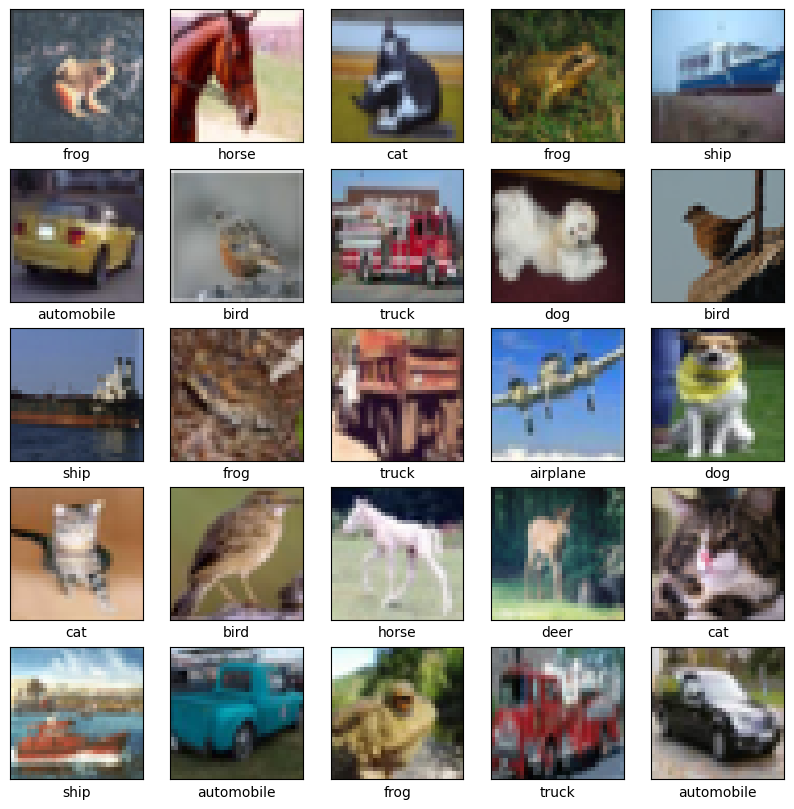

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Losowy wybór 25 indeksów obrazów
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for i, idx in enumerate(random_indices):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])
    plt.xlabel(class_names[train_labels[idx][0]])
plt.show()

In [6]:
# Normalizacja pikseli do zakresu [0, 1]
train_images, test_images = (train_images / 255.0), (test_images / 255.0)

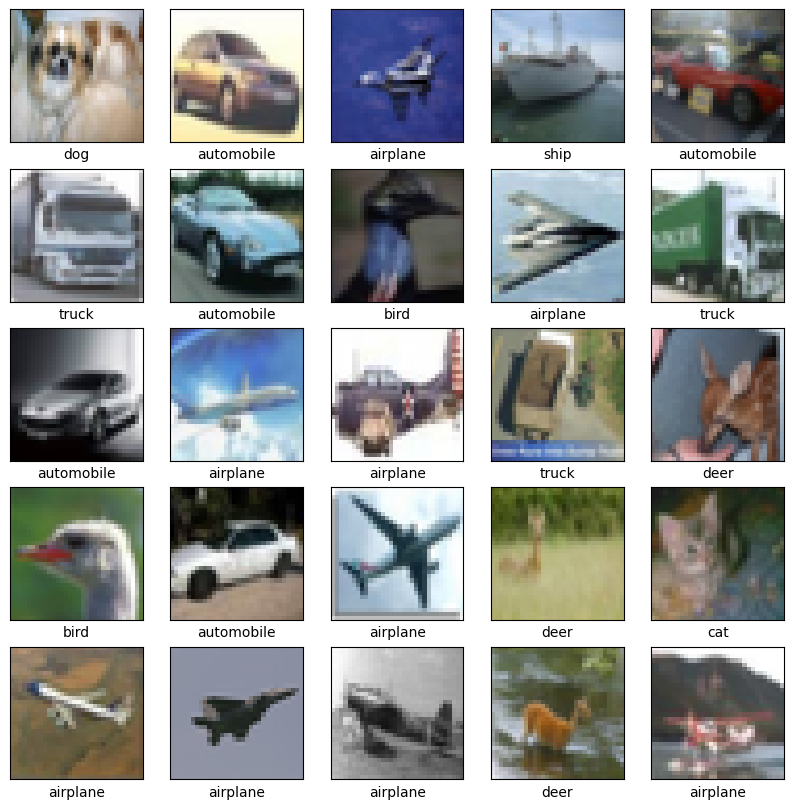

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Losowy wybór 25 indeksów obrazów
np.random.seed()
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for i, idx in enumerate(random_indices):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])
    plt.xlabel(class_names[train_labels[idx][0]])
plt.show()

Zbiór danych CIFAR-10 składa się z kolorowych obrazów 32x32.

In [20]:
index = 7
# obrazki 32x32
train_images[index].shape, train_labels[index][0]

((32, 32, 3), 7)

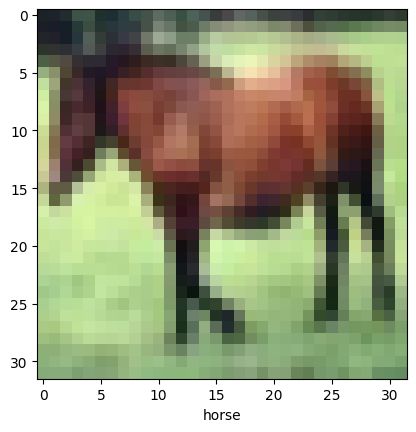

In [21]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow(train_images[index])
plt.xlabel(class_names[train_labels[index][0]])
plt.show()

Zbiór danych składa się z 60000 obrazów. Istnieje 50000 obrazów treningowych i 10000 obrazów testowych.

In [16]:
train_images.shape,test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

Łączymy te zbiory, żeby później losowe je przemieszać i wybrać zbiory treningowy, walidacyjny oraz testowy.

In [17]:
all_images = np.concatenate((train_images, test_images), axis=0)
all_images.shape

(60000, 32, 32, 3)

W zbiorze danych etykiety są zapisane jako lista, gdzie każdy element jest tablicą z konkretną etykietą. Poniżej proste przekształcenie, żeby uzyskać listę etykiet.

In [23]:
train_labels = train_labels.reshape(-1)
train_labels

test_labels = test_labels.reshape(-1)
test_labels

train_labels,test_labels

(array([6, 9, 9, ..., 9, 1, 1], dtype=uint8),
 array([3, 8, 8, ..., 5, 1, 7], dtype=uint8))

In [24]:
all_labels = np.concatenate((train_labels, test_labels))
all_labels, len(all_labels)

(array([6, 9, 9, ..., 5, 1, 7], dtype=uint8), 60000)

In [25]:
from sklearn.model_selection import train_test_split

# Podział na zbiór treningowy (65%) i tymczasowy (35% na walidacyjny i testowy)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.35, random_state=123, stratify=all_labels)

# Podział tymczasowego zbioru na walidacyjny (15%) i testowy (20%)
valid_images, test_images, valid_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5714, random_state=123, stratify=temp_labels)

In [26]:
train_images.shape,valid_images.shape,test_images.shape,

((39000, 32, 32, 3), (9000, 32, 32, 3), (12000, 32, 32, 3))

(32, 32, 3) 0


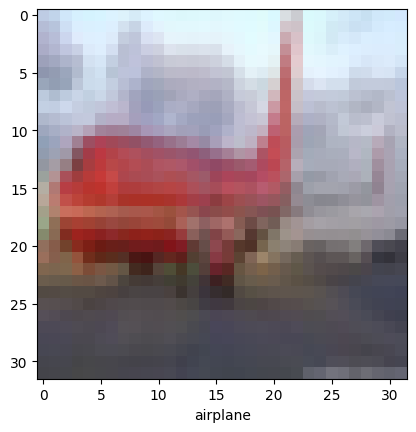

In [29]:
index = 1

print(train_images[index].shape, train_labels[index])

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow(train_images[index])
plt.xlabel(class_names[train_labels[index]])
plt.show()

***

## Wielowarstwowy perceptron

Zaczymy od budowy prostej sieci MLP. Korzystamy z implementacji klasy wielowarstwowego perceptronu z zajęć (z jedną warstwą ukrytą, sigmoidalną funkcją aktywacji oraz średniokwadratową funkcją straty).

In [30]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

# Do konertowania etykiet liczbowych na wektorowe one-hot:
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class NeuralNetMLP:
    # Inicjalizacja macierzy wag i wektora obciążenia dla warstwy ukrytej oraz dla warstwy wyjściowej:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [33]:
print("Kształt train_images:", train_images.shape)
print("Kształt train_labels:", train_labels.shape)

print("Kształt valid_images:", valid_images.shape)
print("Kształt valid_labels:", valid_labels.shape)

print("Kształt test_images:", test_images.shape)
print("Kształt test_labels:", test_labels.shape)

Kształt train_images: (39000, 32, 32, 3)
Kształt train_labels: (39000,)
Kształt valid_images: (9000, 32, 32, 3)
Kształt valid_labels: (9000,)
Kształt test_images: (12000, 32, 32, 3)
Kształt test_labels: (12000,)


In [34]:
train_images = train_images.reshape(train_images.shape[0], -1)
# train_labels = train_labels.reshape(train_labels.shape[0], -1)

valid_images = valid_images.reshape(valid_images.shape[0], -1)
# valid_labels = valid_labels.reshape(valid_labels.shape[0], -1)

test_images = test_images.reshape(test_images.shape[0], -1)
# test_labels = test_labels.reshape(test_labels.shape[0], -1)

In [35]:
print("Kształt train_images:", train_images.shape)
print("Kształt train_labels:", train_labels.shape)

print("Kształt valid_images:", valid_images.shape)
print("Kształt valid_labels:", valid_labels.shape)

print("Kształt test_images:", test_images.shape)
print("Kształt test_labels:", test_labels.shape)

Kształt train_images: (39000, 3072)
Kształt train_labels: (39000,)
Kształt valid_images: (9000, 3072)
Kształt valid_labels: (9000,)
Kształt test_images: (12000, 3072)
Kształt test_labels: (12000,)


In [ ]:
train_images.shape[1], len(np.unique(train_labels))

(3072, 10)

In [ ]:
# Tworzymy obiekt klasy NeuralNetMLP z 100 neuronami w warstwie ukrytej:
num_features = train_images.shape[1]
num_hidden = 100
num_classes = len(np.unique(train_labels))
neural_net = NeuralNetMLP(num_features, num_hidden, num_classes)

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

# Sprawdzenie, czy powyższa funkcja działa poprawnie
# (zaczynamy iterację po zbiorze danych, przerywamy i wypisujemy rozmiar mini-wsadu)

# Iterujemy po epokach:
for i in range(num_epochs):
    # Iterujemy po mini-wsadach
    minibatch_gen = minibatch_generator(
        train_images, train_labels, minibatch_size)
    for train_images_mini, train_labels_mini in minibatch_gen:
        break
    break

print(train_images_mini.shape)
print(train_labels_mini.shape)

(100, 3072)
(100,)


In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [ ]:
_, probas = neural_net.forward(valid_images)
mse = mse_loss(valid_labels, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(valid_labels, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 10.0%


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
# Sprawdźmy, czy tą funkcją wychodzi tyle samo co wcześniej:
mse, acc = compute_mse_and_acc(neural_net, valid_images, valid_labels)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 10.0%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

# Definicja parametrów
num_epochs = 50
learning_rate = 0.5

# Uruchomienie treningu
train_loss, train_acc, valid_acc = train(neural_net, train_images, train_labels, valid_images, valid_labels, num_epochs, learning_rate)


Epoch: 001/050 | Train MSE: 0.08 | Train Acc: 32.84% | Valid Acc: 32.41%
Epoch: 002/050 | Train MSE: 0.08 | Train Acc: 37.26% | Valid Acc: 36.74%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 39.19% | Valid Acc: 38.71%
Epoch: 004/050 | Train MSE: 0.07 | Train Acc: 40.31% | Valid Acc: 39.24%
Epoch: 005/050 | Train MSE: 0.07 | Train Acc: 42.23% | Valid Acc: 40.72%
Epoch: 006/050 | Train MSE: 0.07 | Train Acc: 41.91% | Valid Acc: 40.56%
Epoch: 007/050 | Train MSE: 0.07 | Train Acc: 43.13% | Valid Acc: 41.09%
Epoch: 008/050 | Train MSE: 0.07 | Train Acc: 44.45% | Valid Acc: 42.66%
Epoch: 009/050 | Train MSE: 0.07 | Train Acc: 43.41% | Valid Acc: 41.12%
Epoch: 010/050 | Train MSE: 0.07 | Train Acc: 46.30% | Valid Acc: 44.32%
Epoch: 011/050 | Train MSE: 0.07 | Train Acc: 44.21% | Valid Acc: 41.09%
Epoch: 012/050 | Train MSE: 0.07 | Train Acc: 45.88% | Valid Acc: 42.67%
Epoch: 013/050 | Train MSE: 0.07 | Train Acc: 47.22% | Valid Acc: 43.82%
Epoch: 014/050 | Train MSE: 0.07 | Train Acc: 46.13

Poniżej przedstawiamy inne wyniki, które wyszły gdy zmienialiśmy różne parametry.

In [ ]:
# num_hidden = 50  # liczba neuronów w warstwie ukrytej
# learning_rate = 0.1
# Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 20.05% | Valid Acc: 19.93%
# ...
# Epoch: 050/050 | Train MSE: 0.07 | Train Acc: 46.20% | Valid Acc: 43.09%

In [ ]:
# num_hidden = 50  # liczba neuronów w warstwie ukrytej
# learning_rate = 0.5
# Epoch: 001/050 | Train MSE: 0.08 | Train Acc: 30.80% | Valid Acc: 30.11%
# ...
# Epoch: 050/050 | Train MSE: 0.06 | Train Acc: 52.53% | Valid Acc: 45.72%

In [ ]:
# num_hidden = 100
# learning_rate = 0.1
# Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 24.30% | Valid Acc: 23.87%
# ...
# Epoch: 050/050 | Train MSE: 0.07 | Train Acc: 48.41% | Valid Acc: 45.83%

Najlepsze wyniki otrzymaliśmy, gdy `num_hidden = 100` oraz `learning_rate = 0.5`.

In [ ]:
# num_hidden = 100
# learning_rate = 0.5
# Epoch: 001/050 | Train MSE: 0.08 | Train Acc: 32.84% | Valid Acc: 32.41%
# ...
# Epoch: 050/050 | Train MSE: 0.06 | Train Acc: 57.36% | Valid Acc: 48.06%

Poniżej przedstawiamy wykresy z wartościami dla funkcji straty na zbiorze treningowym oraz dokładność na zbiorze treningowym i na zbiorze walidacyjnym dla uczonego modelu z wszystkich epok uczenia.

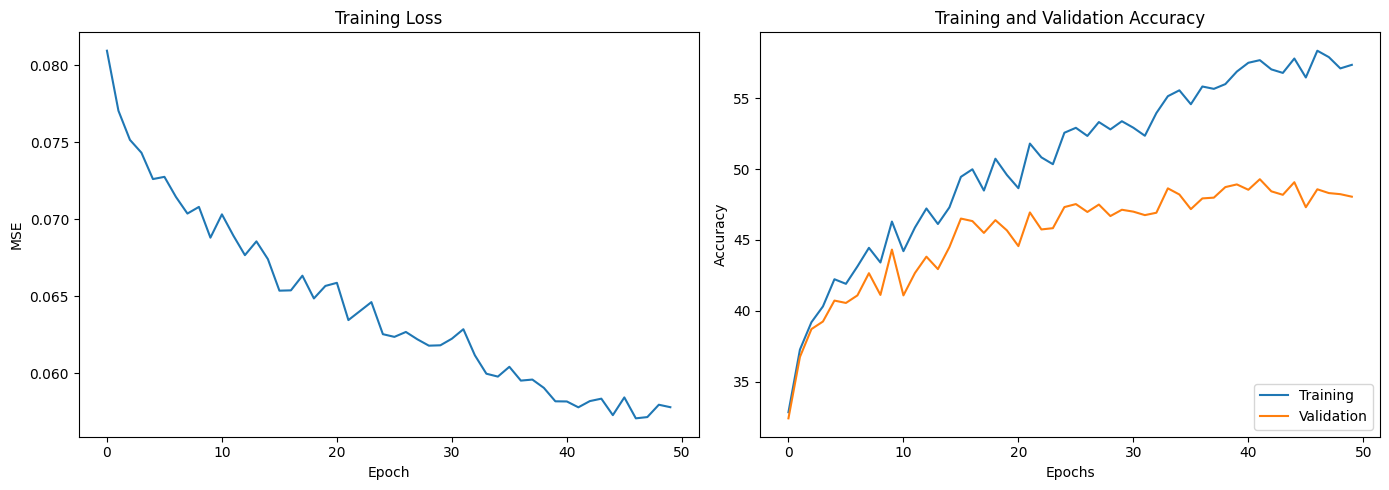

In [ ]:
# Tworzymy subploty
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Pierwszy wykres: MSE
ax[0].plot(range(len(train_loss)), train_loss)
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training Loss')

# Drugi wykres: Accuracy
ax[1].plot(range(len(train_acc)), train_acc, label='Training')
ax[1].plot(range(len(valid_acc)), valid_acc, label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

***

Budujemy sieć MLP wykorzystując moduł `torch.nn`.

In [36]:
import torch
import torch.nn as nn

Ponownie ładujemy nasz zbiór danych.

In [104]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [105]:
train_labels = train_labels.reshape(-1)
train_labels

test_labels = test_labels.reshape(-1)
test_labels

train_labels,test_labels

(array([6, 9, 9, ..., 9, 1, 1], dtype=uint8),
 array([3, 8, 8, ..., 5, 1, 7], dtype=uint8))

In [106]:
train_images.shape,train_images[0].shape

((50000, 32, 32, 3), (32, 32, 3))

In [107]:
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [108]:
train_images.shape, train_images[0].shape

((50000, 3072), (3072,))

In [109]:
# Standaryzacja + obiekt TensorDataset (ze zbiorem uczącym) + odpowiadający obiekt DataLoader:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_images_norm = (train_images - np.mean(train_images)) / np.std(train_images) # standaryzacja
train_images_norm = torch.from_numpy(train_images_norm).float()
train_labels = torch.from_numpy(train_labels)

train_ds = TensorDataset(train_images_norm, train_labels)

torch.manual_seed(1)
batch_size = 50
# batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Korzystamy z implementacji klasy z zajęć, którą będziemy modyfikować.

In [110]:
# sieć MLP
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = train_images_norm.shape[1]
hidden_size = 256
output_size = 10

model0 = Model(input_size, hidden_size, output_size)

learning_rate = 0.05

loss_fn = nn.CrossEntropyLoss()

import torch.optim as optim
optimizer = optim.SGD(model0.parameters(), lr=learning_rate)

num_epochs = 25

loss_hist = [0]*num_epochs
accuracy_hist = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model0(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_hist[epoch]:.4f}, Accuracy: {accuracy_hist[epoch]*100:.2f}%')


Epoch: 1/25, Loss: 2.1747, Accuracy: 29.49%
Epoch: 2/25, Loss: 2.0743, Accuracy: 38.74%
Epoch: 3/25, Loss: 2.0367, Accuracy: 42.48%
Epoch: 4/25, Loss: 2.0061, Accuracy: 45.63%
Epoch: 5/25, Loss: 1.9858, Accuracy: 47.55%
Epoch: 6/25, Loss: 1.9685, Accuracy: 49.29%
Epoch: 7/25, Loss: 1.9523, Accuracy: 51.06%
Epoch: 8/25, Loss: 1.9388, Accuracy: 52.36%
Epoch: 9/25, Loss: 1.9268, Accuracy: 53.54%
Epoch: 10/25, Loss: 1.9151, Accuracy: 54.75%
Epoch: 11/25, Loss: 1.9048, Accuracy: 55.87%
Epoch: 12/25, Loss: 1.8960, Accuracy: 56.75%
Epoch: 13/25, Loss: 1.8860, Accuracy: 57.76%
Epoch: 14/25, Loss: 1.8791, Accuracy: 58.36%
Epoch: 15/25, Loss: 1.8706, Accuracy: 59.24%
Epoch: 16/25, Loss: 1.8639, Accuracy: 59.95%
Epoch: 17/25, Loss: 1.8575, Accuracy: 60.64%
Epoch: 18/25, Loss: 1.8515, Accuracy: 61.12%
Epoch: 19/25, Loss: 1.8448, Accuracy: 61.91%
Epoch: 20/25, Loss: 1.8376, Accuracy: 62.56%
Epoch: 21/25, Loss: 1.8335, Accuracy: 62.97%
Epoch: 22/25, Loss: 1.8277, Accuracy: 63.57%
Epoch: 23/25, Loss:

Poniżej w zakomentowanych komórkach znajduje się porównanie wyników dla `batch_size = 32` oraz `batch_size = 50`.

In [ ]:
# batch_size = 32
# hidden_size = 256
# learning_rate = 0.05
# Epoch: 1/25, Loss: 2.1452, Accuracy: 31.96%
# ...
# Epoch: 25/25, Loss: 1.8225, Accuracy: 63.78%

# batch_size = 50
# hidden_size = 256
# learning_rate = 0.05
# Epoch: 1/25, Loss: 2.1747, Accuracy: 29.49%
# ...
# Epoch: 25/25, Loss: 1.8121, Accuracy: 65.16%

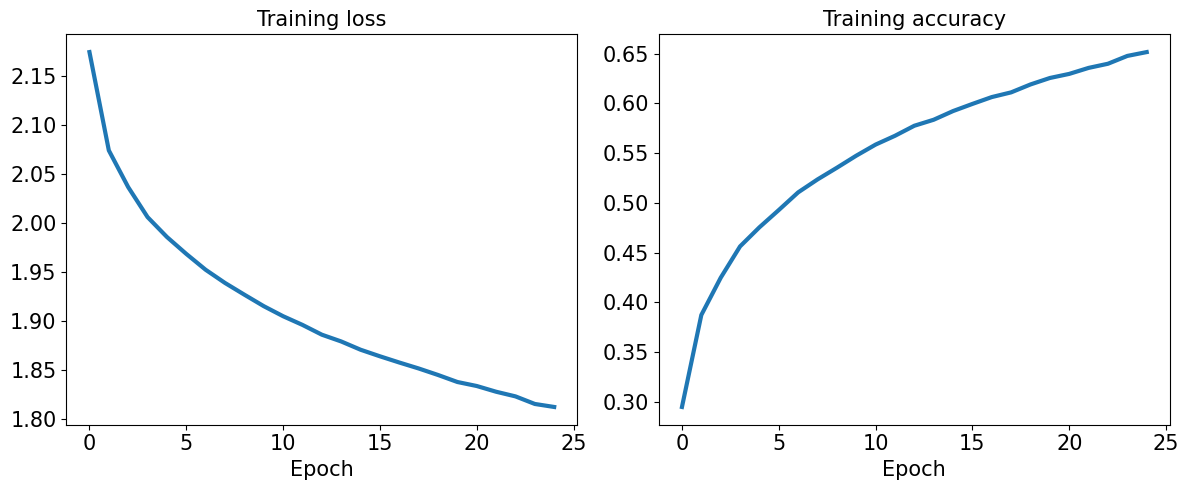

In [111]:
# Wizualizacja procesu uczenia:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

Sprawdzamy na zbiorze testowym.

In [112]:
test_images_norm = (test_images - np.mean(test_images)) / np.std(test_images)
test_images_norm = torch.from_numpy(test_images_norm).float()
test_labels = torch.from_numpy(test_labels)

pred_test = model0(test_images_norm)

correct = (torch.argmax(pred_test, dim=1) == test_labels).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.5168


In [ ]:
# batch_size = 32
# Test Acc.: 0.5103

# batch_size = 50
# Test Acc.: 0.5168

In [113]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x =nn.Sigmoid()(x)
        return x

input_size = train_images_norm.shape[1]
hidden_size = 1024
output_size = 10

model0 = Model(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()

import torch.optim as optim
optimizer = optim.SGD(model0.parameters(), lr=learning_rate)

num_epochs = 25

loss_hist = [0]*num_epochs
accuracy_hist = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model0(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_hist[epoch]:.4f}, Accuracy: {accuracy_hist[epoch]*100:.2f}%')
    # the best



Epoch: 1/25, Loss: 1.9887, Accuracy: 38.23%
Epoch: 2/25, Loss: 1.9170, Accuracy: 44.20%
Epoch: 3/25, Loss: 1.8874, Accuracy: 46.65%
Epoch: 4/25, Loss: 1.8660, Accuracy: 48.75%
Epoch: 5/25, Loss: 1.8488, Accuracy: 50.34%
Epoch: 6/25, Loss: 1.8336, Accuracy: 51.86%
Epoch: 7/25, Loss: 1.8198, Accuracy: 53.04%
Epoch: 8/25, Loss: 1.8078, Accuracy: 53.91%
Epoch: 9/25, Loss: 1.7960, Accuracy: 55.48%
Epoch: 10/25, Loss: 1.7857, Accuracy: 56.06%
Epoch: 11/25, Loss: 1.7759, Accuracy: 57.00%
Epoch: 12/25, Loss: 1.7665, Accuracy: 58.06%
Epoch: 13/25, Loss: 1.7585, Accuracy: 58.73%
Epoch: 14/25, Loss: 1.7498, Accuracy: 59.60%
Epoch: 15/25, Loss: 1.7422, Accuracy: 60.31%
Epoch: 16/25, Loss: 1.7348, Accuracy: 60.95%
Epoch: 17/25, Loss: 1.7271, Accuracy: 61.82%
Epoch: 18/25, Loss: 1.7215, Accuracy: 62.37%
Epoch: 19/25, Loss: 1.7141, Accuracy: 63.09%
Epoch: 20/25, Loss: 1.7083, Accuracy: 63.70%
Epoch: 21/25, Loss: 1.7025, Accuracy: 64.39%
Epoch: 22/25, Loss: 1.6974, Accuracy: 64.77%
Epoch: 23/25, Loss:

In [ ]:
# batch_size = 32
# hidden_size = 1024
# learning_rate = 0.1
# Epoch: 1/25, Loss: 1.9753, Accuracy: 38.80%
# ...
# Epoch: 25/25, Loss: 1.6914, Accuracy: 65.22%

# batch_size = 50
# hidden_size = 1024
# learning_rate = 0.1
# Epoch: 1/25, Loss: 1.9898, Accuracy: 38.23%
# ...
# Epoch: 25/25, Loss: 1.6825, Accuracy: 66.50%
# the best

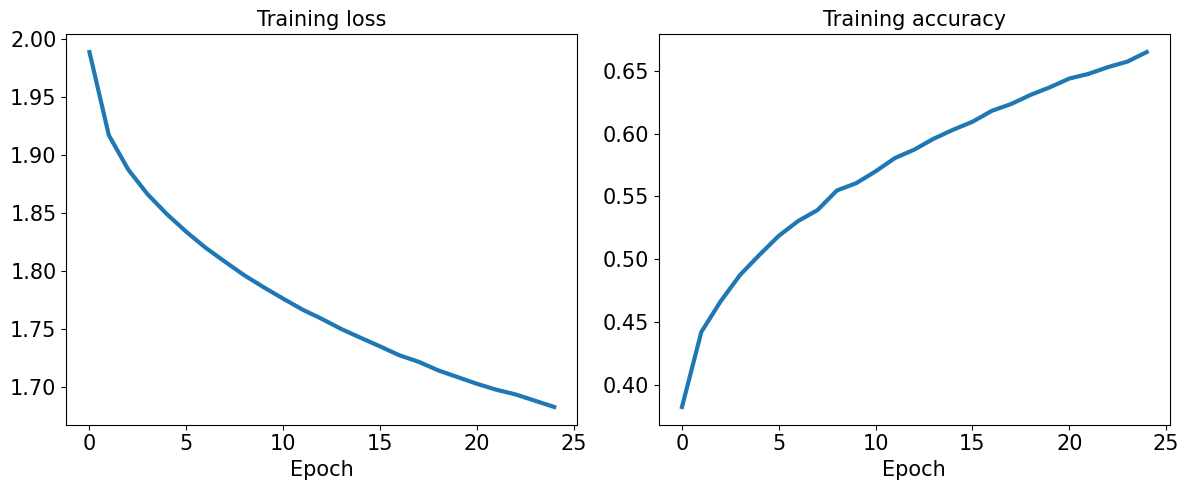

In [114]:
# Wizualizacja procesu uczenia:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()
# the best

Sprawdzamy na zbiorze testowym.

In [115]:
pred_test = model0(test_images_norm)

correct = (torch.argmax(pred_test, dim=1) == test_labels).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')
# the best

Test Acc.: 0.5269


In [ ]:
# batch_size = 32
# Test Acc.: 0.5181

# batch_size = 50
# Test Acc.: 0.5269
# the best

In [116]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.Softmax(dim=1)(x)
        return x

model0 = Model()

learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model0.parameters(), lr=learning_rate)

num_epochs = 25

loss_hist = [0]*num_epochs
accuracy_hist = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model0(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_hist[epoch]:.4f}, Accuracy: {accuracy_hist[epoch]*100:.2f}%')


Epoch: 1/25, Loss: 2.1259, Accuracy: 33.56%
Epoch: 2/25, Loss: 2.0336, Accuracy: 42.60%
Epoch: 3/25, Loss: 2.0021, Accuracy: 45.67%
Epoch: 4/25, Loss: 1.9780, Accuracy: 48.02%
Epoch: 5/25, Loss: 1.9589, Accuracy: 49.98%
Epoch: 6/25, Loss: 1.9417, Accuracy: 51.75%
Epoch: 7/25, Loss: 1.9301, Accuracy: 52.97%
Epoch: 8/25, Loss: 1.9193, Accuracy: 54.01%
Epoch: 9/25, Loss: 1.9100, Accuracy: 54.97%
Epoch: 10/25, Loss: 1.8997, Accuracy: 55.96%
Epoch: 11/25, Loss: 1.8904, Accuracy: 56.91%
Epoch: 12/25, Loss: 1.8819, Accuracy: 57.83%
Epoch: 13/25, Loss: 1.8762, Accuracy: 58.36%
Epoch: 14/25, Loss: 1.8705, Accuracy: 58.89%
Epoch: 15/25, Loss: 1.8618, Accuracy: 59.83%
Epoch: 16/25, Loss: 1.8540, Accuracy: 60.66%
Epoch: 17/25, Loss: 1.8484, Accuracy: 61.20%
Epoch: 18/25, Loss: 1.8439, Accuracy: 61.70%
Epoch: 19/25, Loss: 1.8365, Accuracy: 62.35%
Epoch: 20/25, Loss: 1.8345, Accuracy: 62.61%
Epoch: 21/25, Loss: 1.8297, Accuracy: 63.05%
Epoch: 22/25, Loss: 1.8216, Accuracy: 63.82%
Epoch: 23/25, Loss:

In [ ]:
# batch_size = 32
# learning_rate = 0.1
# Epoch: 1/25, Loss: 2.1059, Accuracy: 35.19%
# ...
# Epoch: 25/25, Loss: 1.9310, Accuracy: 52.89%

# batch_size = 50
# learning_rate = 0.1
# Epoch: 1/25, Loss: 2.1259, Accuracy: 33.56%
# ...
# Epoch: 25/25, Loss: 1.8106, Accuracy: 64.98%

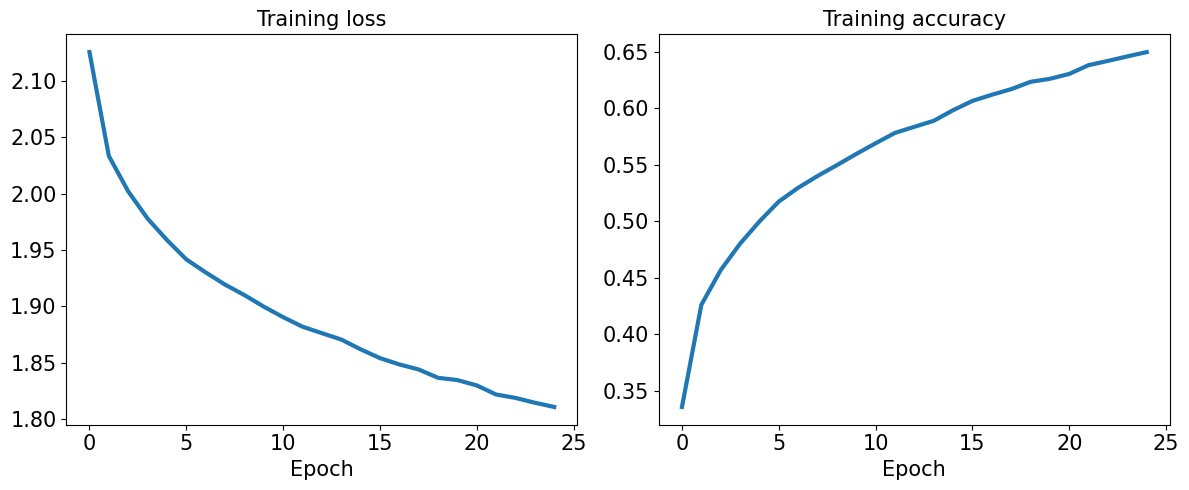

In [117]:
# Wizualizacja procesu uczenia:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

Sprawdzamy na zbiorze testowym.

In [118]:
pred_test = model0(test_images_norm)

correct = (torch.argmax(pred_test, dim=1) == test_labels).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.5220


In [ ]:
# batch_size = 32
# Test Acc.: 0.4664

# batch_size = 50
# Test Acc.: 0.5220

In [119]:
# sieć MLP
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = train_images_norm.shape[1]
hidden_size = 1024
output_size = 10

model0 = Model(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()

import torch.optim as optim
optimizer = optim.SGD(model0.parameters(), lr=learning_rate)

num_epochs = 25

loss_hist = [0]*num_epochs
accuracy_hist = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model0(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_hist[epoch]:.4f}, Accuracy: {accuracy_hist[epoch]*100:.2f}%')


Epoch: 1/25, Loss: 2.1246, Accuracy: 33.56%
Epoch: 2/25, Loss: 2.0324, Accuracy: 42.57%
Epoch: 3/25, Loss: 1.9987, Accuracy: 46.03%
Epoch: 4/25, Loss: 1.9755, Accuracy: 48.29%
Epoch: 5/25, Loss: 1.9589, Accuracy: 49.95%
Epoch: 6/25, Loss: 1.9450, Accuracy: 51.33%
Epoch: 7/25, Loss: 1.9282, Accuracy: 53.18%
Epoch: 8/25, Loss: 1.9163, Accuracy: 54.37%
Epoch: 9/25, Loss: 1.9070, Accuracy: 55.29%
Epoch: 10/25, Loss: 1.8967, Accuracy: 56.23%
Epoch: 11/25, Loss: 1.8873, Accuracy: 57.24%
Epoch: 12/25, Loss: 1.8786, Accuracy: 58.10%
Epoch: 13/25, Loss: 1.8698, Accuracy: 59.01%
Epoch: 14/25, Loss: 1.8612, Accuracy: 59.98%
Epoch: 15/25, Loss: 1.8548, Accuracy: 60.54%
Epoch: 16/25, Loss: 1.8457, Accuracy: 61.43%
Epoch: 17/25, Loss: 1.8391, Accuracy: 62.13%
Epoch: 18/25, Loss: 1.8366, Accuracy: 62.42%
Epoch: 19/25, Loss: 1.8299, Accuracy: 63.08%
Epoch: 20/25, Loss: 1.8240, Accuracy: 63.69%
Epoch: 21/25, Loss: 1.8133, Accuracy: 64.71%
Epoch: 22/25, Loss: 1.8084, Accuracy: 65.29%
Epoch: 23/25, Loss:

In [ ]:
# batch_size = 32
# hidden_size = 1024
# learning_rate = 0.1
# Epoch: 1/25, Loss: 2.1047, Accuracy: 35.39%
# ...
# Epoch: 25/25, Loss: 1.9205, Accuracy: 53.94%

# batch_size = 50
# hidden_size = 1024
# learning_rate = 0.1
# Epoch: 1/25, Loss: 2.1246, Accuracy: 33.56%
# ...
# Epoch: 25/25, Loss: 1.7927, Accuracy: 66.85%

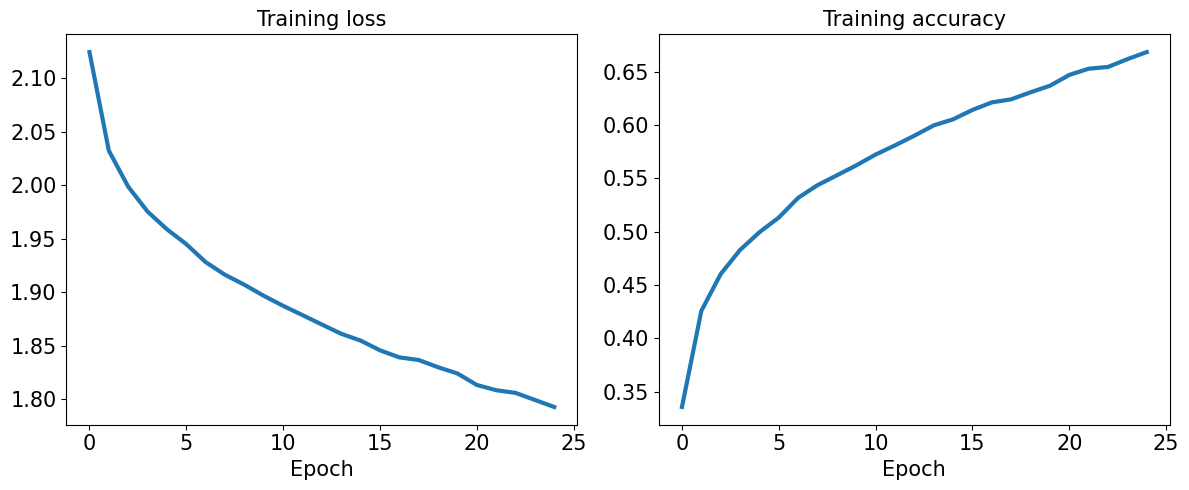

In [120]:
# Wizualizacja procesu uczenia:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

Sprawdzamy na zbiorze testowym.

In [121]:
pred_test = model0(test_images_norm)

correct = (torch.argmax(pred_test, dim=1) == test_labels).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.5247


In [ ]:
# batch_size = 32
# Test Acc.: 0.4711

# batch_size = 50
# Test Acc.: 0.5247

***

## Konwolucyjne sieci neuronowe

W kolejnej części podejdziemy do problemu z użyciem sieci CNN.

Zaczniemy od przekonwertowania danych na parę tensor+etykieta, z której będzie korzystał nasz model.

In [ ]:
from statistics import mean

In [ ]:
import torch
n=len(all_images)
print(n)
images=[]
for i in range(0,n):
  a=torch.from_numpy(all_images[i])
  b=torch.transpose(a,1,2)
  c=torch.transpose(b,0,1)
  images.append((c.float(),all_labels[i]))

60000


In [ ]:
images[1][0].shape

torch.Size([3, 32, 32])

Dokonujemy przemieszania danych, żeby samodzielnie stworzyć zbiory treningowy, walidacyjny oraz testowy.

In [ ]:
np.random.seed(1)
import random
random.shuffle(images)

In [ ]:
images[1]

(tensor([[[0.3647, 0.3647, 0.3725,  ..., 0.3137, 0.3098, 0.3137],
          [0.3765, 0.3765, 0.3882,  ..., 0.3412, 0.3412, 0.3451],
          [0.3882, 0.3882, 0.3922,  ..., 0.3686, 0.3608, 0.3569],
          ...,
          [0.7216, 0.7176, 0.6275,  ..., 0.6980, 0.7059, 0.7020],
          [0.7255, 0.7216, 0.7176,  ..., 0.7059, 0.7020, 0.7059],
          [0.7137, 0.7137, 0.7176,  ..., 0.7020, 0.7137, 0.7020]],
 
         [[0.3725, 0.3725, 0.3804,  ..., 0.3176, 0.3137, 0.3176],
          [0.3843, 0.3843, 0.3961,  ..., 0.3451, 0.3451, 0.3490],
          [0.3961, 0.3961, 0.4000,  ..., 0.3725, 0.3647, 0.3608],
          ...,
          [0.7373, 0.7333, 0.6392,  ..., 0.7059, 0.7137, 0.7098],
          [0.7412, 0.7373, 0.7294,  ..., 0.7137, 0.7098, 0.7137],
          [0.7294, 0.7294, 0.7333,  ..., 0.7098, 0.7216, 0.7098]],
 
         [[0.3294, 0.3294, 0.3373,  ..., 0.2941, 0.2902, 0.2941],
          [0.3412, 0.3412, 0.3529,  ..., 0.3216, 0.3216, 0.3255],
          [0.3529, 0.3529, 0.3569,  ...,

In [ ]:
type(images[1])
type(images[1][0])

torch.Tensor

In [ ]:
images[1][0].shape

torch.Size([3, 32, 32])

Wydzielenie podzbiorów treningowego, walidacyjnego i testowego

In [ ]:
from torch.utils.data import Subset
train_images = Subset(images, torch.arange(39000))
valid_images=Subset(images,torch.arange(39000,48000))
test_dataset = Subset(images, torch.arange(48000, len(images)))

#model 1 - analogiczny do modelu z zajęć zaproponowanego w lab 8 
(delikatne zmiany parametrów ze względu na różne parametry obrazków)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_images, batch_size, shuffle=True)
valid_dl = DataLoader(valid_images, batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [ ]:
model.add_module('flatten', nn.Flatten())

In [ ]:
model.add_module('fc1', nn.Linear(4096, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4534 val_accuracy: 0.5367
Epoch 2 accuracy: 0.5775 val_accuracy: 0.6187
Epoch 3 accuracy: 0.6365 val_accuracy: 0.6529
Epoch 4 accuracy: 0.6820 val_accuracy: 0.6740
Epoch 5 accuracy: 0.7212 val_accuracy: 0.6934
Epoch 6 accuracy: 0.7532 val_accuracy: 0.7028
Epoch 7 accuracy: 0.7844 val_accuracy: 0.7008
Epoch 8 accuracy: 0.8132 val_accuracy: 0.7163
Epoch 9 accuracy: 0.8434 val_accuracy: 0.7162
Epoch 10 accuracy: 0.8667 val_accuracy: 0.7026
Epoch 11 accuracy: 0.8839 val_accuracy: 0.7146
Epoch 12 accuracy: 0.8984 val_accuracy: 0.7142
Epoch 13 accuracy: 0.9134 val_accuracy: 0.7161
Epoch 14 accuracy: 0.9227 val_accuracy: 0.7117
Epoch 15 accuracy: 0.9292 val_accuracy: 0.7178
Epoch 16 accuracy: 0.9341 val_accuracy: 0.7168
Epoch 17 accuracy: 0.9358 val_accuracy: 0.7170
Epoch 18 accuracy: 0.9414 val_accuracy: 0.7046
Epoch 19 accuracy: 0.9476 val_accuracy: 0.7163
Epoch 20 accuracy: 0.9499 val_accuracy: 0.7118


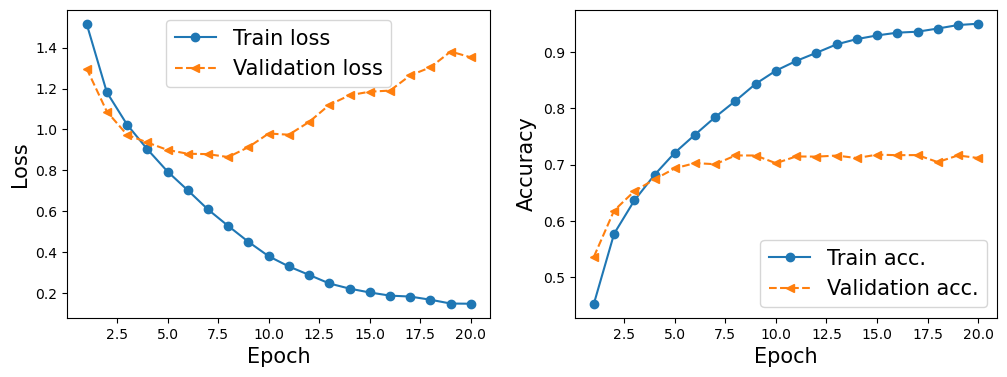

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

Wykres wskazuje na przeuczenie modelu na co wskazuje zwiększający się w drugiej połowie błąd na walidzie.

In [ ]:
test_images=[]
test_labels=[]
n=len(test_dataset)
for i in range(0,n):
  test_images.append(test_dataset[i][0])
  test_labels.append(test_dataset[i][1])

In [ ]:
test=torch.stack(test_images)
test.shape

torch.Size([12000, 3, 32, 32])

Sprawdzamy na zbiorze testowym.

In [ ]:
pred = model(test)
is_correct=[]
n=len(test_labels)
for i in range(0,n):
  is_correct.append(int(torch.argmax(pred, dim=1)[i] == test_labels[i]))
print(f'Test accuracy: {mean(is_correct):.4f}')

Test accuracy: 0.7158


In [ ]:
e=[]
for i in range(n):
    if(is_correct[i]==0):
        e.append(i)
f=[]
for i in range(12):
    f.append(e[i])

f

[6, 8, 17, 21, 22, 25, 32, 37, 49, 50, 65, 67]

Widać, że źle przyporządkowane przykłady są dość mocno rozrzucone. Kolejne modele będą wariacją modelu podstawowego - aby porównać ich jakość. Będą też liczone na tych samych danych.

#Model 2 - zwiększenie ilości warstw o jedną warstwę konwolucyjną

In [ ]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_images, batch_size, shuffle=True)
valid_dl = DataLoader(valid_images, batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

In [ ]:
model.add_module('fc1', nn.Linear(2048, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4220 val_accuracy: 0.5277
Epoch 2 accuracy: 0.5699 val_accuracy: 0.6100
Epoch 3 accuracy: 0.6394 val_accuracy: 0.6662
Epoch 4 accuracy: 0.6879 val_accuracy: 0.6830
Epoch 5 accuracy: 0.7266 val_accuracy: 0.7173
Epoch 6 accuracy: 0.7575 val_accuracy: 0.7202
Epoch 7 accuracy: 0.7839 val_accuracy: 0.7359
Epoch 8 accuracy: 0.8110 val_accuracy: 0.7369
Epoch 9 accuracy: 0.8336 val_accuracy: 0.7237
Epoch 10 accuracy: 0.8548 val_accuracy: 0.7294
Epoch 11 accuracy: 0.8702 val_accuracy: 0.7290
Epoch 12 accuracy: 0.8875 val_accuracy: 0.7264
Epoch 13 accuracy: 0.8997 val_accuracy: 0.7423
Epoch 14 accuracy: 0.9116 val_accuracy: 0.7399
Epoch 15 accuracy: 0.9185 val_accuracy: 0.7357
Epoch 16 accuracy: 0.9260 val_accuracy: 0.7334
Epoch 17 accuracy: 0.9266 val_accuracy: 0.7246
Epoch 18 accuracy: 0.9319 val_accuracy: 0.7294
Epoch 19 accuracy: 0.9376 val_accuracy: 0.7362
Epoch 20 accuracy: 0.9429 val_accuracy: 0.7354


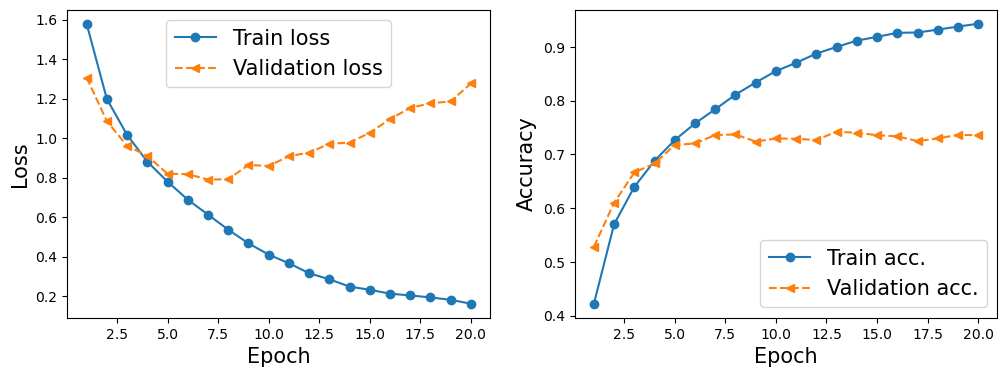

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_images=[]
test_labels=[]
n=len(test_dataset)
for i in range(0,n):
  test_images.append(test_dataset[i][0])
  test_labels.append(test_dataset[i][1])

test=torch.stack(test_images)

Sprawdzamy na zbiorze testowym.

In [ ]:
pred = model(test)
is_correct=[]
n=len(test_labels)
for i in range(0,n):
  is_correct.append(int(torch.argmax(pred, dim=1)[i] == test_labels[i]))
print(f'Test accuracy: {mean(is_correct):.4f}')

Test accuracy: 0.7309


Przeuczenie dalej widoczne, ale delikatna poprawa dzięki dodatkowej warstwie. Widać dość wysoki wynik - wyższy niż w modelu bazowym.

#Model 3 - ze względu na przeuczenie wracamy do modelu podstawowego i dwukrotnie zmieniajszamy learning rate

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_images, batch_size, shuffle=True)
valid_dl = DataLoader(valid_images, batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

In [ ]:
model.add_module('fc1', nn.Linear(4096, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4311 val_accuracy: 0.5118
Epoch 2 accuracy: 0.5473 val_accuracy: 0.5807
Epoch 3 accuracy: 0.6030 val_accuracy: 0.6289
Epoch 4 accuracy: 0.6433 val_accuracy: 0.6551
Epoch 5 accuracy: 0.6753 val_accuracy: 0.6824
Epoch 6 accuracy: 0.7017 val_accuracy: 0.6784
Epoch 7 accuracy: 0.7209 val_accuracy: 0.6988
Epoch 8 accuracy: 0.7491 val_accuracy: 0.7001
Epoch 9 accuracy: 0.7732 val_accuracy: 0.7074
Epoch 10 accuracy: 0.7922 val_accuracy: 0.7057
Epoch 11 accuracy: 0.8103 val_accuracy: 0.7228
Epoch 12 accuracy: 0.8329 val_accuracy: 0.7267
Epoch 13 accuracy: 0.8498 val_accuracy: 0.7234
Epoch 14 accuracy: 0.8659 val_accuracy: 0.7243
Epoch 15 accuracy: 0.8789 val_accuracy: 0.7272
Epoch 16 accuracy: 0.8937 val_accuracy: 0.7322
Epoch 17 accuracy: 0.9042 val_accuracy: 0.7318
Epoch 18 accuracy: 0.9138 val_accuracy: 0.7241
Epoch 19 accuracy: 0.9205 val_accuracy: 0.7196
Epoch 20 accuracy: 0.9304 val_accuracy: 0.7286


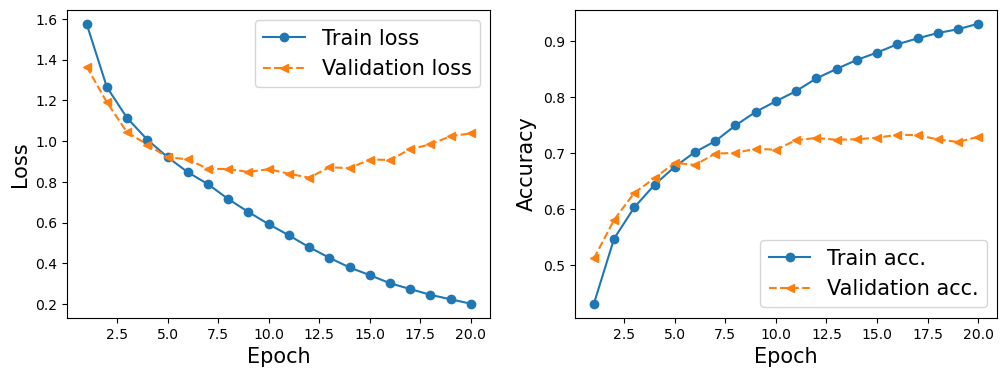

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_images=[]
test_labels=[]
n=len(test_dataset)
for i in range(0,n):
  test_images.append(test_dataset[i][0])
  test_labels.append(test_dataset[i][1])
test=torch.stack(test_images)

Sprawdzamy na zbiorze testowym.

In [ ]:
pred = model(test)
is_correct=[]
n=len(test_labels)
for i in range(0,n):
  is_correct.append(int(torch.argmax(pred, dim=1)[i] == test_labels[i]))
print(f'Test accuracy: {mean(is_correct):.4f}')

Test accuracy: 0.7253


Poziom przeuczenia zmniejszony, widoczna również delikatna poprawa w stosunku do pierszego bazowego modelu.

#Model 4 - stosujemy funkcje ELU zamiast Relu w bazowym modelu, aby sprawdzić jak zachowa się model złożony z delikatnie zmienionych klocków

In [ ]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_images, batch_size, shuffle=True)
valid_dl = DataLoader(valid_images, batch_size, shuffle=False)

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('elu1', nn.ELU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('elu2', nn.ELU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

In [ ]:
model.add_module('fc1', nn.Linear(4096, 1024))
model.add_module('elu3', nn.ELU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4896 val_accuracy: 0.5036
Epoch 2 accuracy: 0.5917 val_accuracy: 0.5946
Epoch 3 accuracy: 0.6322 val_accuracy: 0.6267
Epoch 4 accuracy: 0.6619 val_accuracy: 0.6407
Epoch 5 accuracy: 0.6868 val_accuracy: 0.6548
Epoch 6 accuracy: 0.7188 val_accuracy: 0.6624
Epoch 7 accuracy: 0.7467 val_accuracy: 0.6822
Epoch 8 accuracy: 0.7814 val_accuracy: 0.6967
Epoch 9 accuracy: 0.8089 val_accuracy: 0.6901
Epoch 10 accuracy: 0.8416 val_accuracy: 0.6917
Epoch 11 accuracy: 0.8675 val_accuracy: 0.7027
Epoch 12 accuracy: 0.8838 val_accuracy: 0.7024
Epoch 13 accuracy: 0.9044 val_accuracy: 0.6994
Epoch 14 accuracy: 0.9141 val_accuracy: 0.7020
Epoch 15 accuracy: 0.9185 val_accuracy: 0.7033
Epoch 16 accuracy: 0.9242 val_accuracy: 0.6930
Epoch 17 accuracy: 0.9321 val_accuracy: 0.7006
Epoch 18 accuracy: 0.9336 val_accuracy: 0.6979
Epoch 19 accuracy: 0.9430 val_accuracy: 0.6892
Epoch 20 accuracy: 0.9429 val_accuracy: 0.6973


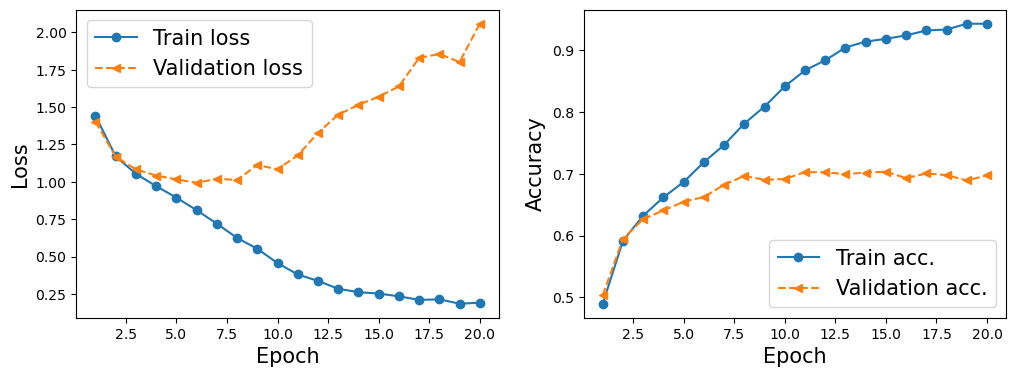

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
test_images=[]
test_labels=[]
n=len(test_dataset)
for i in range(0,n):
  test_images.append(test_dataset[i][0])
  test_labels.append(test_dataset[i][1])
test=torch.stack(test_images)

Sprawdzamy na zbiorze testowym.

In [ ]:
pred = model(test)
is_correct=[]
n=len(test_labels)
for i in range(0,n):
  is_correct.append(int(torch.argmax(pred, dim=1)[i] == test_labels[i]))
print(f'Test accuracy: {mean(is_correct):.4f}')

Test accuracy: 0.6953


Widzimy że jakość spadła, widoczne także duże przeuczenie.

#MODEL 5 - final. Z racji tego że mniejszy learning rate i dodatkowa warstwa były pomocne - używamy ich w dodatkowym modelu
learning rate na poziomie jeszcze niższym - 0.0003

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_images, batch_size, shuffle=True)
valid_dl = DataLoader(valid_images, batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())

In [ ]:
model.add_module('fc1', nn.Linear(2048, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.3726 val_accuracy: 0.4676
Epoch 2 accuracy: 0.5037 val_accuracy: 0.5364
Epoch 3 accuracy: 0.5563 val_accuracy: 0.5823
Epoch 4 accuracy: 0.6005 val_accuracy: 0.6131
Epoch 5 accuracy: 0.6365 val_accuracy: 0.6386
Epoch 6 accuracy: 0.6639 val_accuracy: 0.6580
Epoch 7 accuracy: 0.6911 val_accuracy: 0.6772
Epoch 8 accuracy: 0.7143 val_accuracy: 0.6950
Epoch 9 accuracy: 0.7339 val_accuracy: 0.7053
Epoch 10 accuracy: 0.7514 val_accuracy: 0.7089
Epoch 11 accuracy: 0.7675 val_accuracy: 0.7101
Epoch 12 accuracy: 0.7828 val_accuracy: 0.7173
Epoch 13 accuracy: 0.8042 val_accuracy: 0.7273
Epoch 14 accuracy: 0.8148 val_accuracy: 0.7207
Epoch 15 accuracy: 0.8306 val_accuracy: 0.7342
Epoch 16 accuracy: 0.8477 val_accuracy: 0.7364
Epoch 17 accuracy: 0.8604 val_accuracy: 0.7328
Epoch 18 accuracy: 0.8734 val_accuracy: 0.7387
Epoch 19 accuracy: 0.8861 val_accuracy: 0.7393
Epoch 20 accuracy: 0.8963 val_accuracy: 0.7404


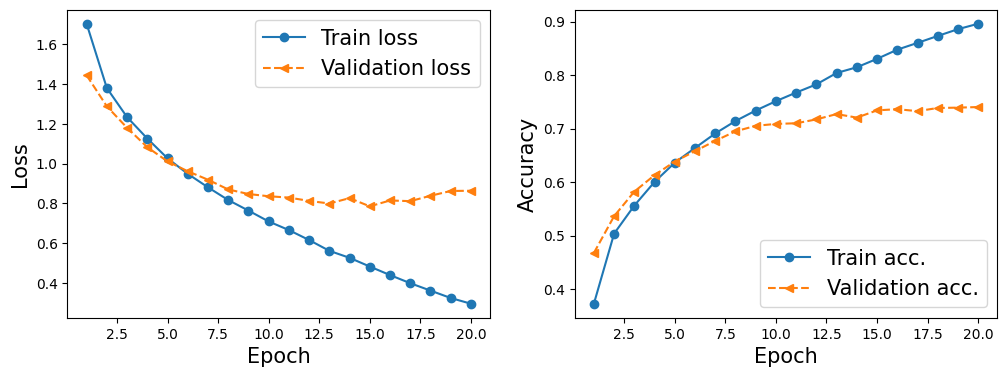

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
test_images=[]
test_labels=[]
n=len(test_dataset)
for i in range(0,n):
  test_images.append(test_dataset[i][0])
  test_labels.append(test_dataset[i][1])

test=torch.stack(test_images)

Sprawdzamy na zbiorze testowym.

In [ ]:
pred = model(test)
is_correct=[]
n=len(test_labels)
for i in range(0,n):
  is_correct.append(int(torch.argmax(pred, dim=1)[i] == test_labels[i]))
print(f'Test accuracy: {mean(is_correct):.4f}')

Test accuracy: 0.7438


Wynik jest nieznacznie, ale najlepszy z dotychczasowych.
W ostatnim kroku pokażemy kilka źle sklasyfikowanych przykładów.

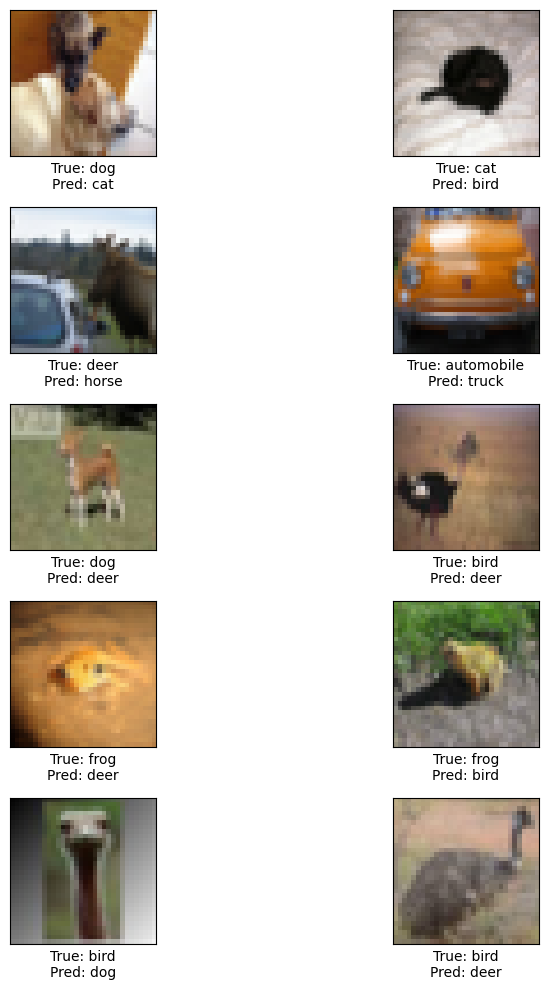

In [ ]:
misclassified_indices = []
predicted_labels = torch.argmax(pred, dim=1)
for i in range(len(test_labels)):
    if predicted_labels[i] != test_labels[i]:
        misclassified_indices.append(i)

num_misclassified_to_display = min(10, len(misclassified_indices))  

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:num_misclassified_to_display]):
    plt.subplot(5, 2, i + 1)  
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[idx].permute(1, 2, 0).numpy()) 
    plt.xlabel(f'True: {class_names[test_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}')

plt.tight_layout()
plt.show()


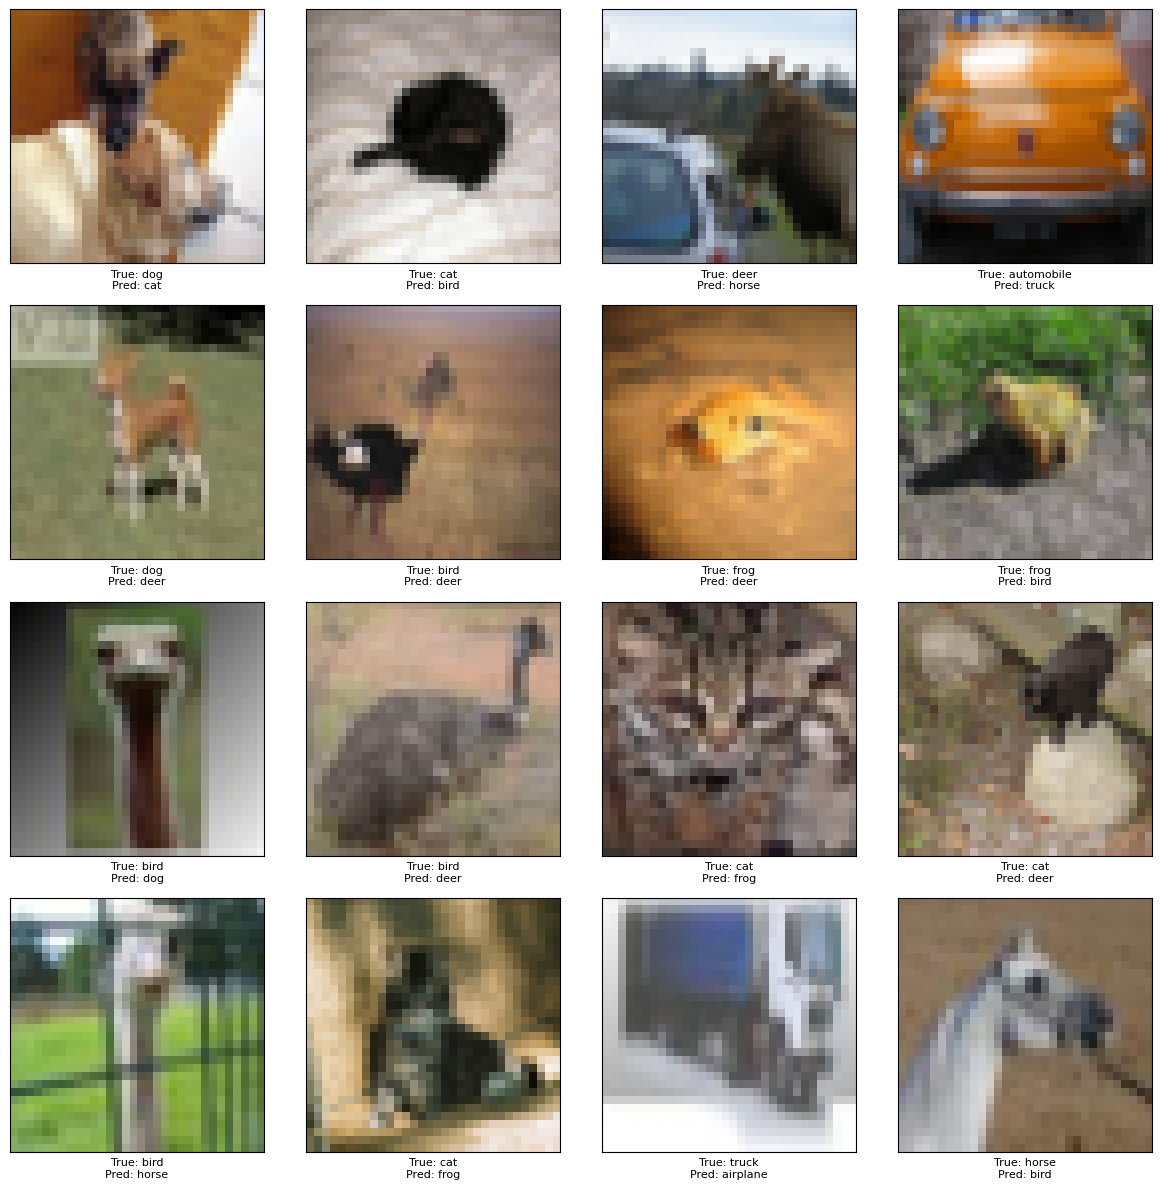

In [ ]:
misclassified_indices = []
predicted_labels = torch.argmax(pred, dim=1)
for i in range(len(test_labels)):
    if predicted_labels[i] != test_labels[i]:
        misclassified_indices.append(i)

num_misclassified_to_display = min(16, len(misclassified_indices)) 

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:num_misclassified_to_display]):
    plt.subplot(4, 4, i + 1)  
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[idx].permute(1, 2, 0).numpy()) 
    plt.xlabel(f'True: {class_names[test_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}', fontsize=8)

plt.tight_layout()
plt.show()
